In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime

In [2]:
company= 'ITC.NS'
endDate= '2023-01-26'

In [3]:
df= yf.download(company, period='max', end= endDate)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-01-01,5.550000,5.600000,5.533333,5.583333,3.303552,985500
1996-01-02,5.466666,5.566666,5.288888,5.372222,3.178642,7470000
1996-01-03,5.133333,5.254444,5.101111,5.200000,3.076742,15160500
1996-01-04,5.200000,5.332222,5.144444,5.297777,3.134594,12397500
1996-01-05,5.297777,5.277777,5.188888,5.202222,3.078057,5008500
...,...,...,...,...,...,...
2023-01-19,334.000000,335.649994,331.649994,332.149994,324.990753,8346130
2023-01-20,332.000000,335.200012,329.250000,334.600006,327.387939,13103664
2023-01-23,336.000000,338.149994,333.049988,337.750000,330.470062,7124807


In [4]:
trainSet= df.iloc[:, 1:2].values

In [5]:
df.shape

(6807, 6)

In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler= MinMaxScaler(feature_range=(0,1))

In [7]:
trainingSetScaled= scaler.fit_transform(df['Close'].values.reshape(-1,1))

In [8]:
xTRAIN = []
yTRAIN = []

for i in range(100, len(trainingSetScaled)):
    xTRAIN.append(trainingSetScaled[i-60:i, 0])
    yTRAIN.append(trainingSetScaled[i, 0])
    
xTRAIN, yTRAIN= np.array(xTRAIN), np.array(yTRAIN)

In [9]:
xTRAIN= np.reshape(xTRAIN, newshape=(xTRAIN.shape[0], xTRAIN.shape[1], 1))

In [10]:
trainingSetScaled.shape

(6807, 1)

In [11]:
xTRAIN.shape

(6707, 60, 1)

In [12]:
yTRAIN.shape

(6707,)

In [13]:
import tensorflow as tf
from tensorflow import keras

In [56]:
regressor= keras.models.Sequential([
    keras.layers.LSTM(units=84, return_sequences= True, input_shape= (xTRAIN.shape[1], 1)),
    keras.layers.Dropout(rate= 0.2),
    keras.layers.LSTM(units=64, return_sequences= True), 
    keras.layers.Dropout(rate= 0.2),
    keras.layers.LSTM(units=50), 
    keras.layers.Dropout(rate= 0.2),
    keras.layers.Dense(units= 1)
])

In [57]:
regressor.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 84)            28896     
                                                                 
 dropout_3 (Dropout)         (None, 60, 84)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 64)            38144     
                                                                 
 dropout_4 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                23000     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [58]:
regressor.compile(optimizer= 'adam', loss= keras.losses.mean_squared_error)

In [59]:
regressor.fit(x= xTRAIN, y=yTRAIN, batch_size= 32, epochs= 100)

Epoch 1/100
210/210 [==============================] - 7s 20ms/step - loss: 0.0061
Epoch 2/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0020
Epoch 3/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0015
Epoch 4/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0015
Epoch 5/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0014
Epoch 6/100
210/210 [==============================] - 4s 20ms/step - loss: 0.0013
Epoch 7/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0013
Epoch 8/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0012
Epoch 9/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0011
Epoch 10/100
210/210 [==============================] - 4s 19ms/step - loss: 0.0011
Epoch 11/100
210/210 [==============================] - 4s 18ms/step - loss: 9.7831e-04
Epoch 12/100
210/210 [==============================] - 4s 18ms/step - loss: 9.62

In [60]:
prdctn= regressor.predict(xTRAIN)

210/210 [==============================] - 2s 8ms/step


import tensorflow as tf

# Load your Keras model
model = tf.keras.models.load_model('../model/exports/ITC.NS/')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.experimental_lower_tensor_list_ops = False  # Disable lowering of tensor list ops
tflite_model = converter.convert()

# Save the converted TensorFlow Lite model
tflite_model_path = '../model/exports/ITCx.NS.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

regressor.save(f"../model/exports/{company}/")

In [61]:
testDF= yf.download(company, period='1d', start=endDate, end=datetime.datetime.now())
testDF

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-01-27,341.799988,348.850006,341.500000,346.000000,338.542236,21040139
2023-01-30,346.899994,351.750000,341.850006,344.799988,337.368103,14091519
2023-01-31,346.000000,355.000000,341.049988,352.350006,344.755402,17134291
2023-02-01,353.000000,365.700012,329.100006,361.399994,353.610291,64518967
2023-02-02,361.600006,384.700012,360.399994,378.600006,370.439575,55745171
...,...,...,...,...,...,...
2023-05-23,426.000000,431.200012,424.200012,429.149994,426.522156,8732608
2023-05-24,428.299988,434.750000,427.000000,433.500000,430.845520,11479706
2023-05-25,436.950012,442.450012,434.799988,441.149994,438.448669,18204464


In [62]:
realSP= testDF['Close'].values

In [63]:
dfTotal= pd.concat((df['Open'], testDF['Open']), axis=0)

In [64]:
modelInp= dfTotal[len(dfTotal)-len(testDF)-60:].values

In [65]:
modelInp= modelInp.reshape(-1,1)

In [66]:
modelInp= scaler.transform(modelInp)

In [67]:
xTEST= []

for i in range(60, len(modelInp)):
    xTEST.append(modelInp[i-60:i, 0])

xTEST= np.array(xTEST)

In [68]:
xTEST.shape

(81, 60)

In [69]:
xTEST= np.reshape(xTEST, newshape= (xTEST.shape[0], xTEST.shape[1], 1))

In [70]:
#pred = pred[..., 0]

In [71]:
pred= regressor.predict(xTEST)

3/3 [==============================] - 0s 21ms/step


In [72]:
pred= scaler.inverse_transform(pred)

In [73]:
pred.shape

(81, 1)

In [74]:
import matplotlib.pyplot as plt

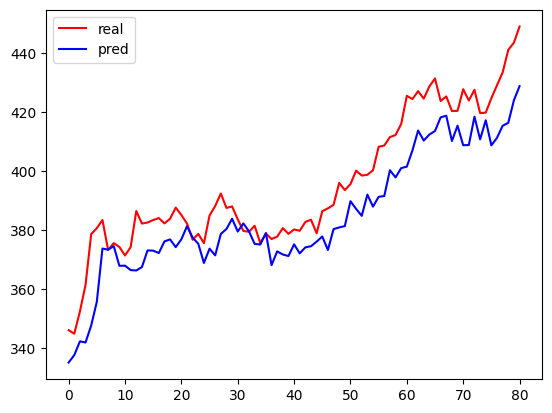

In [75]:
plt.plot(realSP, color= 'r', label= 'real')
plt.plot(pred, color= 'b', label= 'pred')
plt.legend()
plt.show()

In [34]:
realData= [modelInp[len(modelInp)+1-60:len(modelInp+1), 0]]

In [35]:
realData= np.array(realData)

In [36]:
realData= np.reshape(realData, newshape=(realData.shape[0], realData.shape[1], 1))

In [37]:
prediction= regressor.predict(realData)

1/1 [==============================] - 1s 699ms/step


In [38]:
prediction= scaler.inverse_transform(prediction)

In [39]:
prediction

array([[418.8656]], dtype=float32)